# COLLABORATION AND COMPETITION PROJECT - MADDPG

---

In this notebook, we implement a MADDPG model composed of two DDPG agents to solve the environment of the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque

import numpy as np
import torch
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg_agent import MADDPG

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(n_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(n_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (for each agent) for this episode: {}'.format(scores))

Total score (for each agent) for this episode: [ 0.   -0.01]


### 4. Train MADDPG to solve the environment

Here, we instanciate the MADDPG agent and run the training

In [6]:
# Create an agent
agent = MADDPG(state_size=state_size, action_size=action_size, n_agents=n_agents, seed=0)

n_episodes=10000

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
mean_score = []
pretrain_steps = 0

for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations
    score = np.zeros(n_agents, dtype=np.float)
    while True:
        action = agent.act(state, add_noise=True)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations   # get the next state
        reward = env_info.rewards                  # get the reward
        done = env_info.local_done
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if np.any(done):
            break

    scores_window.append(max(score))       # save most recent score
    mean_score.append(np.mean(scores_window))
    scores.append(max(score))              # save most recent score

    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        agent.save()
        break


Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.02
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.03
Episode 900	Average Score: 0.05
Episode 1000	Average Score: 0.08
Episode 1100	Average Score: 0.08
Episode 1200	Average Score: 0.07
Episode 1300	Average Score: 0.07
Episode 1400	Average Score: 0.08
Episode 1500	Average Score: 0.08
Episode 1600	Average Score: 0.08
Episode 1700	Average Score: 0.09
Episode 1800	Average Score: 0.09
Episode 1900	Average Score: 0.08
Episode 2000	Average Score: 0.07
Episode 2100	Average Score: 0.08
Episode 2200	Average Score: 0.09
Episode 2300	Average Score: 0.08
Episode 2400	Average Score: 0.09
Episode 2500	Average Score: 0.10
Episode 2600	Average Score: 0.11
Episode 2700	Average Score: 0.10
Episode 2800	Average Score: 0.10
Episode 2900	Average Score: 0.10
Episode 3000	Average Score: 0.11
Episode 3100	Averag

### 5. Plot the results

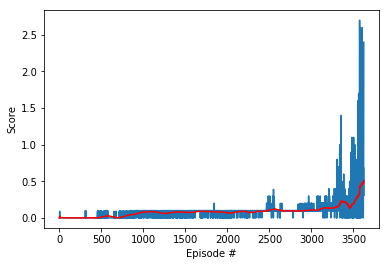

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), mean_score, color='red')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch two smart agents play Tennis!

In the next code cell, we will load the trained weights from files to watch the agents playing!

In [9]:
# load the weights from file
agent.load()

for i_episode in range(5):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations
    score = np.zeros(n_agents, dtype=np.float)
    for j in range(10000):
        action = agent.act(state, add_noise=False)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations   # get the next state
        reward = env_info.rewards                   # get the reward
        done = env_info.local_done                  # see if episode has finished
        score += reward                                # update the score
        state = next_state            
        if np.any(done):
            print('\rEpisode {}\tAgent 1 Score: {:.2f}\tAgent 2 Score: {:.2f}'.format(i_episode, score[0], score[1]))
            break


Episode 0	Agent 1 Score: 2.60	Agent 2 Score: 2.60
Episode 1	Agent 1 Score: -0.01	Agent 2 Score: 0.10
Episode 2	Agent 1 Score: 2.60	Agent 2 Score: 2.60
Episode 3	Agent 1 Score: -0.01	Agent 2 Score: 0.10
Episode 4	Agent 1 Score: 0.00	Agent 2 Score: -0.01


### 7. Close the environment!

In [10]:
env.close()